In [1]:
!pip install transformers -q
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.2 MB/s eta 0:00:00


In [2]:
from datasets import list_datasets, load_dataset
import pandas as pd

In [3]:
all_datasets = list_datasets()
len(all_datasets),all_datasets[:10]

<ipython-input-3-498c39ff4daa>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


(45594,
 ['acronym_identification',
  'ade_corpus_v2',
  'adversarial_qa',
  'aeslc',
  'afrikaans_ner_corpus',
  'ag_news',
  'ai2_arc',
  'air_dialogue',
  'ajgt_twitter_ar',
  'allegro_reviews'])

In [4]:
emotions = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions['train']

In [7]:
train_ds[10]

{'text': 'i feel like i have to make the suffering i m seeing mean something',
 'label': 0}

In [8]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
emotions.set_format(type="pandas")

In [10]:
df = emotions['train'][:]
df.sample(5)

,text,label
391,im sure that the folks in virginia florida and...,3
4138,i came up with the following i m drawing a bla...,4
3499,i now feel a longing for knowledge,2
3582,i feel petty moaning about it but its annoying...,3
3135,i feel content alive and motivated,1


In [11]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


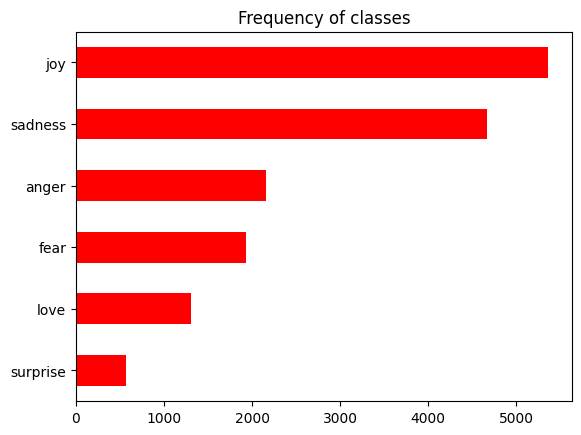

In [12]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh(color='red')
plt.title("Frequency of classes")
plt.show()

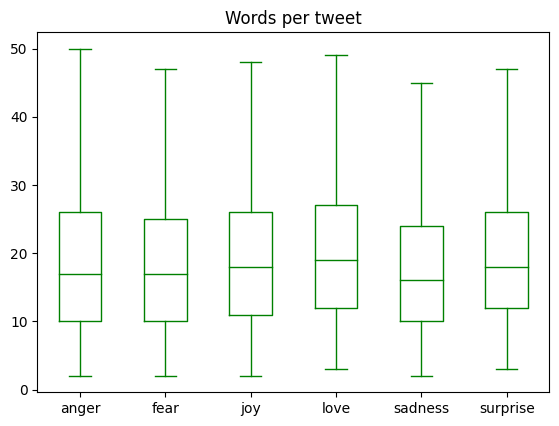

In [13]:
df['Words per tweet'] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name", grid=False,showfliers=False, color="green")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
""" Most Tweets around 15 words long """

' Most Tweets around 15 words long '

In [15]:
# Now we don't need dataset anymore.
emotions.reset_format()

In [17]:
text = "Tokenize text a is a core part of NLP"
tokenized_text = text.split()
tokenized_text

['Tokenize', 'text', 'a', 'is', 'a', 'core', 'part', 'of', 'NLP']